In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numexpr as ne
import time
import copy
import sys

from tqdm import tqdm
from sklearn.metrics import accuracy_score, log_loss

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../pytorch_utils/')
from utils import train, evaluate, get_data, top5_accuracy, per_class_accuracy, count_params

In [3]:
import torch.cuda
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.benchmark = True

# Load data

In [5]:
%%time
X_train, X_val, Y_train, Y_val = get_data()
train_size = len(X_train)
val_size = len(X_val)
print(train_size, val_size)

51200 5120
CPU times: user 1min 31s, sys: 10.3 s, total: 1min 41s
Wall time: 40.6 s


# Create iterators

In [6]:
val_data = TensorDataset(
    torch.FloatTensor(X_val), 
    torch.LongTensor(Y_val)
)

val_iterator = DataLoader(
    val_data, batch_size=64, shuffle=True, pin_memory=True
)

In [7]:
batch_size = 32

In [8]:
train_data = TensorDataset(
    torch.FloatTensor(X_train), 
    torch.LongTensor(Y_train)
)

train_iterator = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Model

In [9]:
from model_densenet import make_model

In [10]:
model, criterion, optimizer = make_model()

In [11]:
count_params(model)

7216256

# Train

In [12]:
n_epochs = 2
validation_step = 200
n_batches = int(np.ceil(train_size/batch_size))
M = 1
T = n_batches*n_epochs
initial = 0.01
n_batches

1600

In [13]:
def lr_scheduler(optimizer, step):
    
    global initial
    decay = np.cos(np.pi*((step - 1) % (T // M))/(T // M)) + 1.0
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = initial*decay/2.0
    
    if (step - 1) % (T // M) == 0 and step != 1:
        # initial *= 0.5
        print('lr is reset:', initial)
        
    return optimizer

In [14]:
all_losses = []
all_models = []

In [15]:
%%time
running_loss = 0.0
running_accuracy = 0.0 
start = time.time()
model.train()

for epoch in range(0, n_epochs):
    for step, (x_batch, y_batch) in enumerate(train_iterator, 1 + epoch*n_batches):
        
        optimizer = lr_scheduler(optimizer, step)
        batch_loss, batch_accuracy = train(
            model, criterion, optimizer, 
            x_batch, y_batch
        )
        running_loss += batch_loss
        running_accuracy += batch_accuracy
        
        if step % validation_step == 0:
            model.eval()
            test_loss, test_accuracy = evaluate(
                model, criterion, val_iterator
            )
            end = time.time()
            
            print('{0:.2f}  {1:.3f} {2:.3f}  {3:.3f} {4:.3f}  {5:.3f}'.format(
                step/n_batches, running_loss/validation_step, test_loss, 
                running_accuracy/validation_step, test_accuracy, end - start
            ))
            all_losses += [(
                step/n_batches,
                running_loss/validation_step, test_loss, 
                running_accuracy/validation_step, test_accuracy
            )] 
            
            running_loss = 0.0
            running_accuracy = 0.0 
            start = time.time()
            model.train()
            
        if step % (T // M) == 0:
            
            print('saving')
            model.cpu()
            clone = copy.deepcopy(model)
            all_models += [clone.state_dict()]
            model.cuda()

0.12  3.286 1.685  0.427 0.676  63.527
0.25  1.402 1.094  0.738 0.767  60.214
0.38  1.072 0.956  0.794 0.802  60.651
0.50  0.971 0.899  0.819 0.810  60.586
0.62  0.921 0.916  0.829 0.810  60.751
0.75  0.868 0.853  0.838 0.814  60.785
0.88  0.818 0.796  0.856 0.835  60.565
1.00  0.798 0.837  0.865 0.822  60.693
1.12  0.709 0.782  0.892 0.848  60.565
1.25  0.722 0.844  0.894 0.820  60.548
1.38  0.700 0.788  0.898 0.844  60.546
1.50  0.686 0.810  0.907 0.837  60.535
1.62  0.682 0.833  0.907 0.828  60.754
1.75  0.673 0.818  0.908 0.836  60.559
1.88  0.680 0.770  0.909 0.844  60.534
2.00  0.664 0.813  0.907 0.832  60.552
saving
CPU times: user 13min 42s, sys: 2min 27s, total: 16min 9s
Wall time: 16min 12s


# Loss/epoch

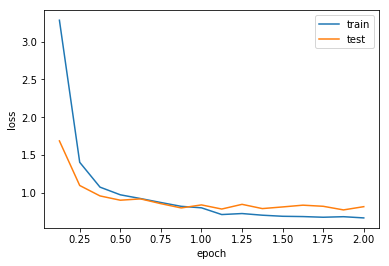

In [16]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='test');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

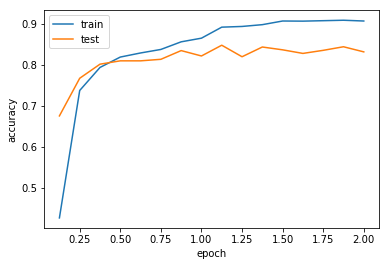

In [17]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='test');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

# Predict val. set

In [18]:
val_predictions = []

In [19]:
val_iterator_no_shuffle = DataLoader(
    val_data, batch_size=32, shuffle=False, pin_memory=True
)

In [20]:
%%time
# model.load_state_dict(all_models[-1])
model.eval()

for x_batch, _ in val_iterator_no_shuffle:

    x_batch = Variable(x_batch.cuda(), volatile=True)
    logits = model(x_batch)

    # compute probabilities
    probs = F.softmax(logits) 
    val_predictions += [probs.cpu().data.numpy()]

CPU times: user 28.9 s, sys: 5.44 s, total: 34.4 s
Wall time: 34.4 s


In [21]:
val_predictions = np.concatenate(val_predictions, axis=0)

In [22]:
accuracy_score(Y_val, val_predictions.argmax(1))

0.84101562500000004

In [23]:
log_loss(Y_val, val_predictions)

0.78847353424383326

In [24]:
top5_accuracy(Y_val, val_predictions)

0.95253906249999998

In [25]:
per_class_acc = per_class_accuracy(Y_val, val_predictions)
per_class_acc

array([ 0.9 ,  0.9 ,  0.75,  0.85,  0.85,  0.85,  0.8 ,  1.  ,  0.95,
        0.75,  1.  ,  1.  ,  0.7 ,  1.  ,  0.9 ,  0.7 ,  0.7 ,  0.65,
        0.9 ,  0.95,  0.85,  0.95,  0.95,  0.9 ,  0.6 ,  0.65,  1.  ,
        0.9 ,  0.95,  0.65,  0.75,  0.85,  0.65,  0.95,  0.8 ,  0.95,
        0.8 ,  0.85,  0.55,  1.  ,  0.9 ,  0.8 ,  0.75,  0.7 ,  0.8 ,
        0.9 ,  1.  ,  0.85,  0.9 ,  0.9 ,  0.75,  0.85,  0.9 ,  0.85,
        0.85,  0.75,  0.95,  0.75,  0.35,  0.75,  0.75,  1.  ,  0.95,
        0.9 ,  0.95,  0.95,  0.8 ,  0.95,  0.75,  0.75,  0.9 ,  1.  ,
        0.9 ,  0.6 ,  0.65,  0.95,  0.95,  0.75,  0.6 ,  0.5 ,  0.85,
        0.75,  0.75,  1.  ,  0.8 ,  0.9 ,  0.9 ,  0.9 ,  0.8 ,  0.95,
        0.9 ,  0.9 ,  0.9 ,  0.95,  0.85,  0.85,  0.65,  0.95,  0.85,
        0.95,  0.95,  1.  ,  0.85,  0.9 ,  0.8 ,  0.85,  0.95,  0.75,
        0.95,  1.  ,  1.  ,  0.95,  0.9 ,  1.  ,  0.7 ,  0.85,  0.85,
        1.  ,  0.9 ,  0.85,  1.  ,  0.6 ,  0.95,  0.9 ,  0.8 ,  0.5 ,
        1.  ,  0.85,

# Error analysis

In [26]:
erroneous = Y_val != val_predictions.argmax(1)
n_errors = len(Y_val[erroneous])
n_errors

814

In [27]:
to_show = np.random.choice(np.arange(0, n_errors), size=30, replace=False)

In [28]:
pictures = X_val[erroneous][to_show].copy()
pictures_predictions = val_predictions.argmax(1)[erroneous][to_show]
pictures_probs = val_predictions.max(1)[erroneous][to_show]
pictures_true = Y_val[erroneous][to_show]

In [29]:
mean = np.array([0.485, 0.456, 0.406], dtype='float32')
std = np.array([0.229, 0.224, 0.225], dtype='float32')
decode = np.load('../utils/decode.npy')[()]

In [30]:
pictures = np.transpose(pictures, axes=(0, 2, 3, 1))
ne.evaluate('pictures*std', out=pictures);
ne.evaluate('pictures + mean', out=pictures);

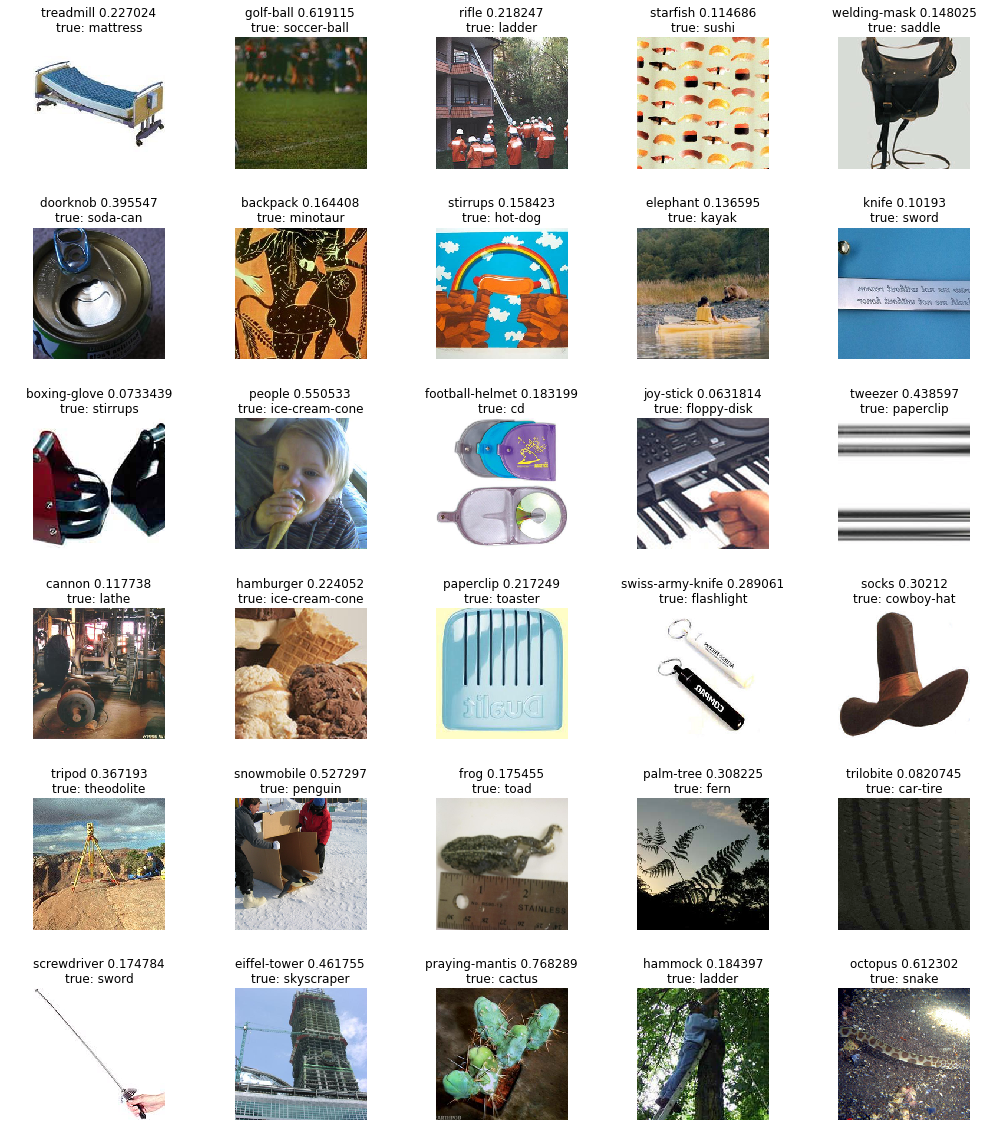

In [31]:
# show pictures, predicted classes and probabilities
_, axes = plt.subplots(nrows=6, ncols=5, figsize=(14, 16))
axes = axes.flatten()
for i, pic in enumerate(pictures):
    axes[i].set_axis_off();
    axes[i].imshow(pic);
    title = decode[pictures_predictions[i] + 1] + ' ' +\
        str(pictures_probs[i]) + '\ntrue: ' + decode[pictures_true[i] + 1]
    axes[i].set_title(title);
plt.tight_layout()

# Save the model

In [32]:
for i, m in enumerate(all_models):
    torch.save(m, 'model_state' + str(i) + '.pytorch')